In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge

sns.set()

In [2]:
# Leemos el dataset
california_housing = fetch_california_housing()

# Y obtenemos los atributos y target
X = california_housing.data
y = california_housing.target

# Transformamos en Pandas
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Unimos a X e y, esto ayuda a la parte de la gráfica del mapa de calor de correlación
df_california = pd.concat([X, y], axis=1)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42)

In [4]:
# Escalemos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo transformemos en DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=california_housing['feature_names'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=california_housing['feature_names'])

## 3. Calcular la regresión lineal usando todos los atributos. Con el set de entrenamiento, calcular la varianza total del modelo y la que es explicada con el modelo. ¿El modelo está capturando el comportamiento del target? Expanda su respuesta.

In [5]:
lin_reg = LinearRegression()
# lin_reg.fit(X_train, y_train)
lin_reg.fit(X_train_scaled, y_train)

# Predicciones en el conjunto de entrenamiento
y_train_pred = lin_reg.predict(X_train_scaled)


In [6]:
y_bar = np.mean(y_train)
y_hat = y_train_pred.copy()

S_e = np.sum((y_train-y_hat)**2)
S_t = np.sum((y_train-y_bar)**2)

S_r = S_t - S_e
print('S_e=', f'{S_e:.2f} - (Residuos)')
print('S_r=', f'{S_r:.2f} - (Parte que explica el modelo)')
print('S_t=', f'{S_t:.2f} - Varianza total')
# S_r, S_e, S_t

S_e= 7561.47 - (Residuos)
S_r= 11794.46 - (Parte que explica el modelo)
S_t= 19355.93 - Varianza total


Ajuste

In [7]:
N = len(X_train_scaled) # samples
d = len(X_train_scaled.columns) # features

s_e = np.sqrt(S_e/(N-d-1))
print('s_e = ', s_e)

s_e =  0.7236600333345641


In [8]:
#Coef de Pearson:
R_2 = S_r/S_t
print("R_2=", R_2)

R_2= 0.6093459727972159


El coeficiente de pearson nos dice que cuanto más cerca de 1 es mejor el ajuste por parte del modelo.

En este caso podríamos argumentar que el coeficiente de pearson no da lo suficientemente cercano a 1. 

En el apartado teórico se menciona que este coeficiente puede dar mal en el caso de que los aparatos de medición sean de mala calidad (ya que aumentan la varianza y no es culpa del modelo), lo cual asumimos que no sucede en este dataset.

Este modelo entonces es malo, esto puede ser debido a que no se hizo una limpieza del dataset como por ejemplo: Eliminar features altamente correlacionadas y outliers. Esto seguramente mejore el modelo bajo la premisa de que 'si entran basura, sale basura'.



## 4.  Calcular las métricas de MSE, MAE y R2 del set de evaluación.

In [9]:
y_test_pred = lin_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print('mse=', f'{mse:.3g}')
print('mae=', f'{mae:.3g}')
print('r2=', f'{r2:.3g}')

mse= 0.531
mae= 0.527
r2= 0.596


Aquí se puede observar que el MSE y el MAE dan resultados similares.
Como se vió en el apartado teórico, el MSE es sensible a los outliers (debido a que está elevado al cuadrado), es por eso que podríamos pensar que el modelo está haciendo overfitting a los outliers (ya que el error entre el mse y el mae no es tan distinto).

## 5.   Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de α, buscando entre [0, 12.5]. Graficar el valor de MSE versus α

best_mse: 0.526817576531949


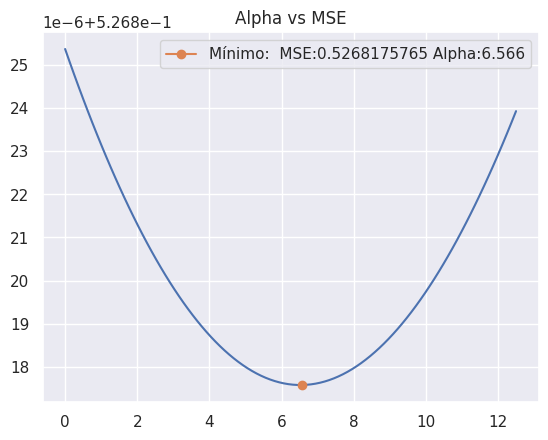

In [10]:
alpha_values = np.linspace(0, 12.5, 100)
MSE = np.array([])
for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    cv = cross_val_score(ridge_model, X_train_scaled, y=y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    mse = -cv.mean()
    MSE = np.append(MSE, mse)

idx = np.argmin(MSE)
best_alpha = alpha_values[idx]
best_mse = MSE[idx]
plt.plot(alpha_values, MSE)
plt.title('Alpha vs MSE')
plt.plot(best_alpha, best_mse, label=f'Mínimo:  MSE:{best_mse:.10g} Alpha:{best_alpha:.4g}', marker='o')
plt.legend()
print('best_mse:', best_mse)

## 6.   Comparar, entre la regresión lineal y la mejor regresión de Ridge, los resultados obtenidos en el set de evaluación. ¿Cuál da mejores resultados (usando MSE y MAE)? Conjeturar por qué el mejor modelo mejora. ¿Qué error puede haberse reducido?



In [11]:
df = pd.DataFrame()
models = []
for name, model in zip(['Ridge', 'Regresión Lineal'],[Ridge(alpha=best_alpha), LinearRegression()]):
    model.fit(X_train_scaled, y_train)
    models.append(model)
    y_test_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    row = {
        'Model': name,
        'MSE': mse,
        'MAE': mae,
    }
    
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
df

,Model,MSE,MAE
0,Ridge,0.530415,0.527222
1,Regresión Lineal,0.530568,0.527247


Como se observó en el anterior punto, el MSE es sensible a outliers.
En este caso si bien Ridge obtuvo un menor MSE, obtuvo un mayor MAE.

Esto seguramente tenga que ver con que el Ridge tiende a generalizar más los otros tipos de datos (no outliers).
Tiene sentido ya que a la regresión lineal le agregamos un término de regularización (alpha).
$$
\sum_{i=0}^{N} (y_{[i]} - b - W^T X_{[i]}) + \underbrace{\alpha \sum_{j=0}^{d-1} w_{j}^2}_\text{regularización}
$$

Esta regularización justamente limita el crecimiento de los coeficientes (de esta forma generalizando mejor, evitando overfitting).

